# Imports

In [1]:
import pandas as pd
import numpy as np
import string
from matplotlib import pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons


# Data Reading

In [2]:
data_frame = pd.read_csv("articles.csv")
data_frame.head()

data_frame = data_frame.head(100)

# Data Cleaning
## 1- Handel Missing values
### a- Handel columns with missing values

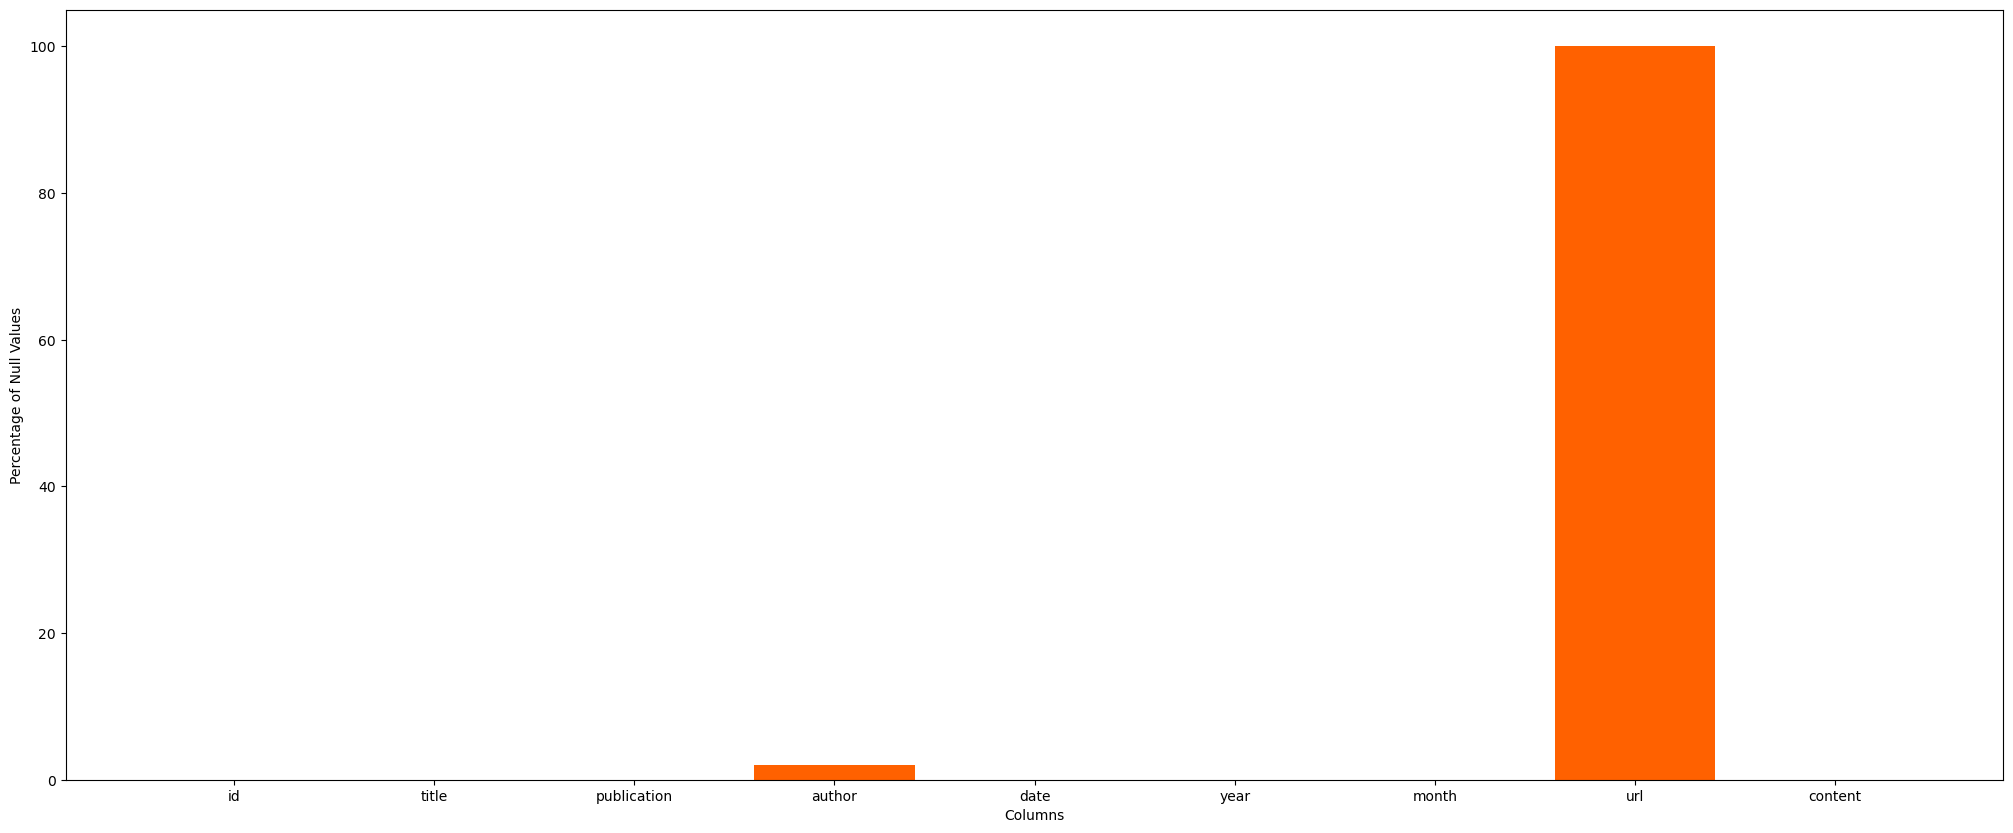

Unnamed: 0       0.0
id               0.0
title            0.0
publication      0.0
author           2.0
date             0.0
year             0.0
month            0.0
url            100.0
content          0.0
dtype: float64


In [3]:
# Get total number of nulls in each column
labels = data_frame.columns.tolist()
labels.pop(0)

data = (data_frame.isnull().sum() / len(data_frame) * 100).tolist()
data.pop(0)
# Creating plot
fig = plt.figure(figsize =(25, 10))
plt.bar(labels,data, color = "#FF6100")
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.show()
print(data_frame.isnull().sum() / len(data_frame) * 100)

In [4]:
# Remove url column because it's empty(100% null values)
data_frame.drop(columns=['url'], inplace=True)
data_frame.isnull().sum() / len(data_frame) * 100

Unnamed: 0     0.0
id             0.0
title          0.0
publication    0.0
author         2.0
date           0.0
year           0.0
month          0.0
content        0.0
dtype: float64

### b- Handel rows with missing values

In [5]:
# Get percentage of number of rows contain missing values
mask = data_frame.isnull().any(axis=1)
rows_with_missing_values = mask.sum() / len(data_frame)*100
print("Number of rows contain null values =", rows_with_missing_values, "%")

Number of rows contain null values = 2.0 %


In [6]:
# Drop rows contain null values
data_frame.dropna(inplace=True)
data_frame.isnull().sum() / len(data_frame) * 100

Unnamed: 0     0.0
id             0.0
title          0.0
publication    0.0
author         0.0
date           0.0
year           0.0
month          0.0
content        0.0
dtype: float64

## 2- Handel columns data types

In [7]:
data_frame.dtypes

Unnamed: 0       int64
id               int64
title           object
publication     object
author          object
date            object
year           float64
month          float64
content         object
dtype: object

In [8]:
data_frame= data_frame.astype({"title": "string",
                               "publication": "string",
                               "author": "string",
                               "date": "datetime64[ns]",
                               "year": "int64",
                               "month": "int64",
                               "content": "string"})

data_frame.dtypes

Unnamed: 0              int64
id                      int64
title                  string
publication            string
author                 string
date           datetime64[ns]
year                    int64
month                   int64
content                string
dtype: object

## 3- Dealing with unnecessary columns

In [9]:
# Drop id column because it contain unnecessary unique values
data_frame.drop(columns=['id'], inplace=True)
data_frame.head()

,Unnamed: 0,title,publication,author,date,year,month,content
0,0,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016,12,WASHINGTON — Congressional Republicans have...
1,1,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017,6,"After the bullet shells get counted, the blood..."
2,2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017,1,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017,4,"Death may be the great equalizer, but it isn’t..."
4,4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017,1,"SEOUL, South Korea — North Korea’s leader, ..."


In [10]:
# extract day from date column and rename column to day
data_frame['date'] = data_frame['date'].astype('string')
data_frame['date'] = data_frame['date'].str.replace("-", "/")
data_frame[["year", "month", "day"]] = data_frame["date"].str.split("/", expand = True)
data_frame['date'] = data_frame['day']
data_frame.drop(columns=["day"], inplace=True)
data_frame.rename(columns={"date": "day"}, inplace=True)
data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,31,2016,12,WASHINGTON — Congressional Republicans have...
1,1,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,19,2017,06,"After the bullet shells get counted, the blood..."
2,2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,06,2017,01,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,10,2017,04,"Death may be the great equalizer, but it isn’t..."
4,4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,02,2017,01,"SEOUL, South Korea — North Korea’s leader, ..."


# Text Preprocessing NLP Pipeline
## 1- Convert to lowercase

In [11]:
columns = ["title", "publication", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].str.lower()

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,house republicans fret about winning their hea...,new york times,carl hulse,31,2016,12,washington — congressional republicans have...
1,1,rift between officers and residents as killing...,new york times,benjamin mueller and al baker,19,2017,06,"after the bullet shells get counted, the blood..."
2,2,"tyrus wong, ‘bambi’ artist thwarted by racial ...",new york times,margalit fox,06,2017,01,"when walt disney’s “bambi” opened in 1942, cri..."
3,3,"among deaths in 2016, a heavy toll in pop musi...",new york times,william mcdonald,10,2017,04,"death may be the great equalizer, but it isn’t..."
4,4,kim jong-un says north korea is preparing to t...,new york times,choe sang-hun,02,2017,01,"seoul, south korea — north korea’s leader, ..."


## 2- Remove HTML Tags

In [12]:
def remove_HTML_tags(text):
    return re.sub(r'<.*?>', "", text)

columns = ["title", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_HTML_tags(x))

## 3- Remove URLs

In [13]:
def remove_URLs(text):
    return re.sub(r'https?://\S+www\.\S+', "", text)

columns = ["title", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_URLs(x))

## 4- Remove Punctuations

In [14]:
punctuation = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans("", "", punctuation))

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_punctuations(x))

## 5- Remove Special Characters

In [15]:
columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].str.replace('[^a-zA-Z0-9]', " ", regex=True)

data_frame[['title', 'content']]

,title,content
0,house republicans fret about winning their hea...,washington congressional republicans have...
1,rift between officers and residents as killing...,after the bullet shells get counted the blood ...
2,tyrus wong bambi artist thwarted by racial b...,when walt disney s bambi opened in 1942 crit...
3,among deaths in 2016 a heavy toll in pop music...,death may be the great equalizer but it isn t ...
4,kim jongun says north korea is preparing to te...,seoul south korea north korea s leader ki...
...,...,...
95,corzine reaches 5 million settlement with regu...,after more than five years of investigations a...
96,sears agrees to sell craftsman to stanley blac...,the question from the analyst on thursday was ...
97,lirr train that crashed was going over twice s...,a long island rail road train that crashed in ...
98,record 2016 for us auto industry long road bac...,detroit unexpectedly strong sales of new ...


## 6- Remove unnecessary spaces and words

In [16]:
# remove unnecessary spaces
columns = ["title", "author", "content"]
for column in columns:
    data_frame[column] = data_frame[column].str.replace('\s\s+', " ", regex=True)

data_frame[['title', 'content']]

,title,content
0,house republicans fret about winning their hea...,washington congressional republicans have a ne...
1,rift between officers and residents as killing...,after the bullet shells get counted the blood ...
2,tyrus wong bambi artist thwarted by racial bia...,when walt disney s bambi opened in 1942 critic...
3,among deaths in 2016 a heavy toll in pop music...,death may be the great equalizer but it isn t ...
4,kim jongun says north korea is preparing to te...,seoul south korea north korea s leader kim sai...
...,...,...
95,corzine reaches 5 million settlement with regu...,after more than five years of investigations a...
96,sears agrees to sell craftsman to stanley blac...,the question from the analyst on thursday was ...
97,lirr train that crashed was going over twice s...,a long island rail road train that crashed in ...
98,record 2016 for us auto industry long road bac...,detroit unexpectedly strong sales of new vehic...


In [17]:
# remove unnecessary words
# remove publication from title
publication_unique_values = data_frame["publication"].unique()
for publication in publication_unique_values:
    data_frame["title"] = data_frame['title'].str.replace("." + publication + "$", "", regex=True)

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,house republicans fret about winning their hea...,new york times,carl hulse,31,2016,12,washington congressional republicans have a ne...
1,1,rift between officers and residents as killing...,new york times,benjamin mueller and al baker,19,2017,06,after the bullet shells get counted the blood ...
2,2,tyrus wong bambi artist thwarted by racial bia...,new york times,margalit fox,06,2017,01,when walt disney s bambi opened in 1942 critic...
3,3,among deaths in 2016 a heavy toll in pop music...,new york times,william mcdonald,10,2017,04,death may be the great equalizer but it isn t ...
4,4,kim jongun says north korea is preparing to te...,new york times,choe sang-hun,02,2017,01,seoul south korea north korea s leader kim sai...


## 7- Apply Tokenization
### a- Apply sentence tokenization

In [18]:
def sentence_tokenizer(text):
    return sent_tokenize(text)

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: sentence_tokenizer(x))

data_frame[['title', 'content']]

,title,content
0,[house republicans fret about winning their he...,[washington congressional republicans have a n...
1,[rift between officers and residents as killin...,[after the bullet shells get counted the blood...
2,[tyrus wong bambi artist thwarted by racial bi...,[when walt disney s bambi opened in 1942 criti...
3,[among deaths in 2016 a heavy toll in pop musi...,[death may be the great equalizer but it isn t...
4,[kim jongun says north korea is preparing to t...,[seoul south korea north korea s leader kim sa...
...,...,...
95,[corzine reaches 5 million settlement with reg...,[after more than five years of investigations ...
96,[sears agrees to sell craftsman to stanley bla...,[the question from the analyst on thursday was...
97,[lirr train that crashed was going over twice ...,[a long island rail road train that crashed in...
98,[record 2016 for us auto industry long road ba...,[detroit unexpectedly strong sales of new vehi...


### b- Apply word tokenization

In [19]:
def word_tokenizer(sentences):
    tokenized_words = []
    for x in sentences:
        tokenized_words = tokenized_words + word_tokenize(x)
    return tokenized_words


columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: word_tokenizer(x))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[house, republicans, fret, about, winning, the...",new york times,carl hulse,31,2016,12,"[washington, congressional, republicans, have,..."
1,1,"[rift, between, officers, and, residents, as, ...",new york times,benjamin mueller and al baker,19,2017,06,"[after, the, bullet, shells, get, counted, the..."
2,2,"[tyrus, wong, bambi, artist, thwarted, by, rac...",new york times,margalit fox,06,2017,01,"[when, walt, disney, s, bambi, opened, in, 194..."
3,3,"[among, deaths, in, 2016, a, heavy, toll, in, ...",new york times,william mcdonald,10,2017,04,"[death, may, be, the, great, equalizer, but, i..."
4,4,"[kim, jongun, says, north, korea, is, preparin...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, s, leader,..."


## 8- Remove Stop Words

In [20]:
STOPWORDS = set(stopwords.words("english"))
def remove_stop_words(text):
    return [word for word in text if word not in STOPWORDS]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_stop_words(x))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[house, republicans, fret, winning, health, ca...",new york times,carl hulse,31,2016,12,"[washington, congressional, republicans, new, ..."
1,1,"[rift, officers, residents, killings, persist,...",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shells, get, counted, blood, dries, v..."
2,2,"[tyrus, wong, bambi, artist, thwarted, racial,...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, opened, 1942, critics, p..."
3,3,"[among, deaths, 2016, heavy, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, may, great, equalizer, necessarily, ev..."
4,4,"[kim, jongun, says, north, korea, preparing, t...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 9- Remove frequently words

In [21]:
word_counter_title = Counter()
word_counter_content = Counter()
def get_most_frequently_words(column_name, word_counter):
    for text in data_frame[column_name]:
        for word in text:
            word_counter[word] += 1
    return word_counter

# get the most common frequently words in [title] more than 1000
word_frequency_title = get_most_frequently_words("title", word_counter_title).most_common(10)

# get the most common frequently words in [content]
word_frequency_content = get_most_frequently_words("content", word_counter_content).most_common(10)

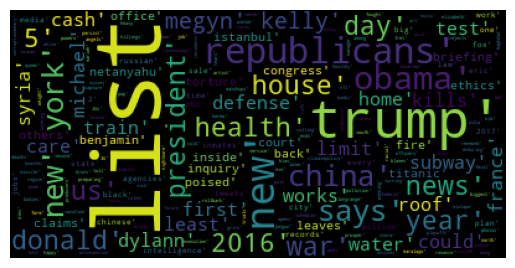

In [22]:
text = data_frame['title'].values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

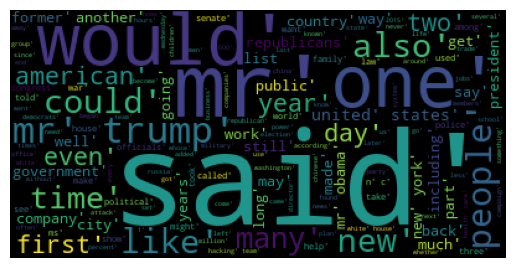

In [23]:
text = data_frame['content'].values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [24]:
FREQUENT_WORDS_TITLE = set(word for (word, word_count) in get_most_frequently_words("title", word_counter_title).most_common(10))
FREQUENT_WORDS_CONTENT = set(word for (word, word_count) in get_most_frequently_words("content", word_counter_content).most_common(10))

def remove_frequent_words(string_text, frequent_words):
    return [word for word in string_text if word not in frequent_words]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_frequent_words(x, FREQUENT_WORDS_TITLE))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[fret, winning, care, suit]",new york times,carl hulse,31,2016,12,"[washington, congressional, fear, comes, care,..."
1,1,"[rift, officers, residents, killings, persist,...",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shells, get, counted, blood, dries, v..."
2,2,"[tyrus, wong, bambi, artist, thwarted, racial,...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, opened, 1942, critics, p..."
3,3,"[among, deaths, heavy, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, may, great, equalizer, necessarily, ev..."
4,4,"[kim, jongun, north, korea, preparing, test, l...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 10- Remove rare words

In [25]:
RARE_WORDS_TITLE = set(word for (word, word_count) in get_most_frequently_words("title", word_counter_title).most_common()[:-10:-1])
RARE_WORDS_CONTENT = set(word for (word, word_count) in get_most_frequently_words("content", word_counter_content).most_common()[:-10:-1])

def remove_rare_words(string_text, rare_words):
    return [word for word in string_text if word not in rare_words]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: remove_rare_words(x, RARE_WORDS_TITLE))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[fret, winning, care, suit]",new york times,carl hulse,31,2016,12,"[washington, congressional, fear, comes, care,..."
1,1,"[rift, officers, residents, killings, persist,...",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shells, get, counted, blood, dries, v..."
2,2,"[tyrus, wong, bambi, artist, thwarted, racial,...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, opened, 1942, critics, p..."
3,3,"[among, deaths, heavy, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, great, equalizer, necessarily, evenhan..."
4,4,"[kim, jongun, north, korea, preparing, test, l...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 11- Apply Stemming

In [26]:
porter_stemmer_title = PorterStemmer()
porter_stemmer_content = PorterStemmer()
def stemming_words(text, porter_stemmer):
    return [porter_stemmer.stem(word) for word in text]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: stemming_words(x, porter_stemmer_title))

data_frame.head()

,Unnamed: 0,title,publication,author,day,year,month,content
0,0,"[fret, win, care, suit]",new york times,carl hulse,31,2016,12,"[washington, congression, fear, come, care, la..."
1,1,"[rift, offic, resid, kill, persist, south, bronx]",new york times,benjamin mueller and al baker,19,2017,06,"[bullet, shell, get, count, blood, dri, votiv,..."
2,2,"[tyru, wong, bambi, artist, thwart, racial, bi...",new york times,margalit fox,06,2017,01,"[walt, disney, bambi, open, 1942, critic, prai..."
3,3,"[among, death, heavi, toll, pop, music]",new york times,william mcdonald,10,2017,04,"[death, great, equal, necessarili, evenhand, f..."
4,4,"[kim, jongun, north, korea, prepar, test, long...",new york times,choe sang-hun,02,2017,01,"[seoul, south, korea, north, korea, leader, ki..."


## 12- Apply POS and Lemmatization

In [27]:
lemmatizer_title = WordNetLemmatizer()
lemmatizer_content = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

def lemmatize_words(text, lemmatizer):
    # apply POS tagging
    pos_text = pos_tag(text)
    return [lemmatizer.lemmatize(word, wordnet_map.get(pos[0],  wordnet.NOUN)) for word, pos in pos_text]

columns = ["title", "content"]
for column in columns:
    data_frame[column] = data_frame[column].apply(lambda x: lemmatize_words(x, lemmatizer_title))

# Data Preprocessing
## 1- Dealing with categorical data (Nominal Data)
### a- Preprocess [ publication ]

In [28]:
# get number of unique values in publication column
publication_unique_values = data_frame["publication"].unique()
print("Publication unique values = ", len(publication_unique_values))

Publication unique values =  1


In [29]:
# apply one hot encoding in publication column
data_frame = pd.get_dummies(data=data_frame, columns=["publication"])
data_frame.dtypes

Unnamed: 0                     int64
title                         object
author                        object
day                           string
year                          string
month                         string
content                       object
publication_new york times     uint8
dtype: object

### b- Preprocess [ author ]

In [30]:
# clean author
def clean_name(name):
    name = name.strip() # remove spaces after and before string
    name = " ".join(name.split()) # remove extra spaces between words
    name = re.sub(r'^.\s|\s.$', "", name) # remove single character in beginning and end of string

    if len(name) > 1:
        return name

author_unique_values = Counter()
def get_unique_names(author_list):
    for name in author_list:
        if name!=None and len(name) > 1:
            author_unique_values[name] += 1 # get unique values

def preprocess_author(text):
    text = re.sub(r'[a-z]{1}\.|\(.*\)', "", text) # remove single character in beginning and end of string
    author_list = re.split('with|and|,|&', text)
    author_list = [clean_name(name) for name in author_list]

    # check if there is a None value
    if None in author_list:
        author_list.remove(None)

    get_unique_names(author_list)
    return author_list

data_frame["author"] = data_frame["author"].apply(lambda x: preprocess_author(x))
data_frame["author"]

0                     [carl hulse]
1     [benjamin mueller, al baker]
2                   [margalit fox]
3               [william mcdonald]
4                  [choe sang-hun]
                  ...             
95                   [ben protess]
96          [michael de la merced]
97              [emma fitzsimmons]
98                   [bill vlasic]
99              [christopher mele]
Name: author, Length: 98, dtype: object

In [31]:
# get number of empty cells in author
result = data_frame['author'].apply(lambda x: isinstance(x, list) and len(x) == 0)
count = result.sum()

# Print the count
print("Number of empty cells is:",count)

Number of empty cells is: 0


In [32]:
# make empty cell = null
data_frame["author"] = data_frame["author"].apply(lambda y: np.nan if len(y)==0 else y)

# remove rows with NaN values
data_frame.dropna(inplace=True)

# get number of empty cells in author
result = data_frame['author'].apply(lambda x: isinstance(x, list) and len(x) == 0)
count = result.sum()

# Print the count
print("Number of empty cells is:",count)

Number of empty cells is: 0


In [33]:
#filtered author column to make each row contain only one author
def filtered_author(author_list):
    frequency = []
    for author in author_list:
        frequency.append(author_unique_values[author])

    # Find the minimum number in the list
    min_number_index = frequency.index(min(frequency))
    return author_list[min_number_index]

data_frame["author"] = data_frame["author"].apply(lambda x: filtered_author(x))

# data_frame["author"]

In [34]:
# apply mapping in author
mapping_author = {}
for index, author in enumerate(list(author_unique_values.keys())):
    mapping_author[author] = index

data_frame = data_frame.replace ({
    "author": mapping_author
})

print("Number of unique values =", len(author_unique_values))
data_frame["author"]

Number of unique values = 93


0      0
1      1
2      3
3      4
4      5
      ..
95    89
96    90
97    16
98    91
99    92
Name: author, Length: 98, dtype: int64

# Feature Extraction
## ⚫ Apply TF-IDF

In [35]:
data_frame['content'] = data_frame["content"].apply(lambda x: " ".join(x))
# Split the content column into training and testing sets
X_train, X_test = train_test_split(data_frame['content'], test_size=0.2, random_state=42)

# Define a TfidfVectorizer to convert the text data into a numerical representation
TF_IDF = TfidfVectorizer(stop_words='english')

# Convert the training data into numerical representations
TF_IDF_features_train = TF_IDF.fit_transform(X_train)

# Convert the document-term matrix to a DataFrame
data_frame_matrix = pd.DataFrame(TF_IDF_features_train.toarray(), columns=TF_IDF.get_feature_names_out())

# Display the document-term matrix
data_frame_matrix

,000,04,053,10,100,101,1036,104,105,106,...,zine,zip,zizit,zlotnick,zone,zoom,zoomin,zoraida,zsa,zurich
0,0.015020,0.0,0.0,0.028391,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.026584,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.019758,0.0,0.0,0.018673,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.014850,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.059292,0.0,0.000000,0.000000,0.0,0.0,0.0
74,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
75,0.000000,0.0,0.0,0.008450,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017093,0.0,0.0,0.000000,0.0,0.018716,0.018716,0.0,0.0,0.0
76,0.042834,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


# Model training and testing
## ⚫ Apply K-Means

In [36]:
# Perform k-means clustering on the training data
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(TF_IDF_features_train)

# Convert the testing data into numerical representations
TF_IDF_features_test = TF_IDF.transform(X_test)

# Predict the clusters for the testing data
y_pred = km.predict(TF_IDF_features_test)
labels = km.labels_
centers = km.cluster_centers_

# Print the top terms in each cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = TF_IDF.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i+1}:")
    for j in order_centroids[i, :10]:
        print(f"  {terms[j]}")
        




Cluster 1:
  kelli
  fox
  news
  nbc
  network
  daytim
  anchor
  viewer
  newsmagazin
  rate
Cluster 2:
  senat
  democrat
  repeal
  ethic
  law
  congress
  care
  mr
  republican
  legisl
Cluster 3:
  mr
  say
  intellig
  hack
  agenc
  russian
  citi
  subway
  thursday
  elit
Cluster 4:
  compani
  carbon
  say
  year
  percent
  bonu
  consum
  store
  murder
  spacex
Cluster 5:
  ship
  app
  wong
  carniv
  photo
  cruis
  titan
  print
  disney
  appl
Cluster 6:
  say
  time
  job
  weight
  rivera
  kerr
  carey
  men
  leahi
  day
Cluster 7:
  tortur
  prison
  afghanistan
  azaria
  mr
  militari
  matti
  riot
  say
  command
Cluster 8:
  soccer
  team
  school
  hockey
  game
  playoff
  player
  yeshiva
  lion
  packer
Cluster 9:
  turkey
  islam
  attack
  turkish
  gunman
  jail
  inmat
  state
  bungat
  erdogan
Cluster 10:
  broadway
  theater
  queen
  week
  church
  gross
  price
  monarch
  sandringham
  jan


In [37]:
# # Create a DataFrame from the centroid values
# centroid_df = pd.DataFrame(order_centroids, columns=terms)

# # Create a heatmap of the centroid values
# sns.heatmap(centroid_df, cmap='Oranges', annot=True)

# # Display the plot
# plt.show()

## ⚫ Apply DBSCAN

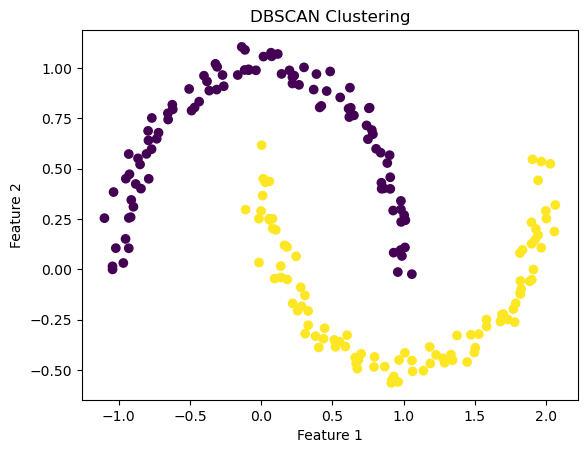

In [38]:
# Generate some random data
TF_IDF_features_train, TF_IDF_features_test = make_moons(n_samples=200, noise=0.05, random_state=42)

# Perform DBSCAN clustering
clustering = DBSCAN(eps=0.3, min_samples=5)
clustering.fit(TF_IDF_features_train)
# Convert the testing data into numerical representations
TF_IDF_features_test = TF_IDF.transform(X_test)

# Predict the clusters for the testing data
y_pred = km.predict(TF_IDF_features_test)
# Plot the clustering results
plt.scatter(TF_IDF_features_train[:, 0], TF_IDF_features_train[:, 1], c=clustering.labels_, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


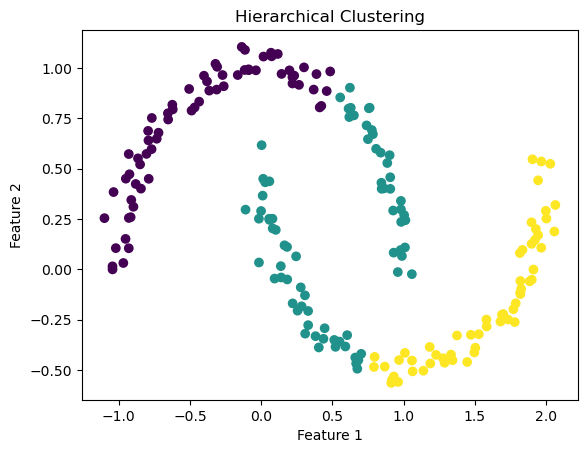

In [39]:
# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=3)
clustering.fit(TF_IDF_features_train)

# Convert the testing data into numerical representations
TF_IDF_features_test = TF_IDF.transform(X_test)

# Predict the clusters for the testing data
y_pred = km.predict(TF_IDF_features_test)
# Plot the clustering results
plt.scatter(TF_IDF_features_train[:, 0], TF_IDF_features_train[:, 1], c=clustering.labels_, cmap='viridis')
plt.title('Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
